In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from cs585_common import crop_video, segment_hands, angle_of_wheel_line

In [2]:
# crop video to length. Do not redo this.
input_video_path = 'data/audi_raw_data.mp4'
output_video_path = 'data/audi_gravel_road_footage.mp4'
start_time = (5 * 60)  # seconds
end_time = (8 * 60 + 30)   # seconds

#crop_video(input_video_path, output_video_path, start_time, end_time)

In [3]:
def crop_road_snippet(frame):
    # consts found by trial and error
    return frame[100:200, 500:800]

WHEEL_OFFSET = np.array((300, 300))
def crop_steering_wheel(frame):
    return frame[300:850, 300:925]

In [4]:
def segment_gravel_road(frame):
    # convert to HSV
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    blurred_frame = cv2.GaussianBlur(hsv_frame, (11, 11), 0)

    lower_gray = np.array([0, 0, 50])
    upper_gray = np.array([179, 50, 220])

    mask = cv2.inRange(blurred_frame, lower_gray, upper_gray)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(largest_contour)

    # Create a mask for the largest contour
    output = np.zeros(mask.shape)
    cv2.drawContours(output, [largest_contour], -1, 1, cv2.FILLED)

    uppermost_point = tuple(hull[hull[:,:,1].argmin()][0])
    
    # Draw the major axis
    ctr = int(mask.shape[1]/2)
    x1, y1 = ctr, mask.shape[0]
    x2, y2 = uppermost_point
    cv2.drawContours(frame, [largest_contour], -1, (0, 255, 0), 5)
    cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

    road_angle = np.rad2deg(np.arctan2((y2 - y1), (x2 - x1)))
    
    return frame, road_angle

def count_l_r_mass(mask):
    # draw centerline
    ctr = int(mask.shape[1]/2)
    
    left_im = mask[0:-1, 0:ctr]
    right_im = mask[0:mask.shape[0], ctr:mask.shape[1]]

    ratio = np.sum(left_im) / np.sum(right_im)

    return ratio

In [5]:
# Open the video file
input_video_path = 'data/audi_gravel_road_footage.mp4'
video_capture = cv2.VideoCapture(input_video_path)

# Loop through frames
while True:
    # Read a frame from the video
    ret, frame = video_capture.read()

    # Check if the frame is successfully read
    if not ret:
        break

    road_frame = crop_road_snippet(frame)
    road_frame, road_angle = segment_gravel_road(road_frame)
    
    wheel_frame = crop_steering_wheel(frame)
    c1, c2 = segment_hands(wheel_frame)
    
    # cv2.line(frame, c1, c2, (0, 255, 0), 2)
    # cv2.circle(frame, c1, 15, (255, 0, 0), -1)
    # cv2.circle(frame, c2, 15, (0, 0, 255), -1)

    angle = angle_of_wheel_line(c1, c2)
    cv2.putText(road_frame, f"Angle: {angle:.4f}", (10, 10), 1, 1, (0, 0, 255))
    cv2.putText(road_frame, f"Angle: {road_angle:.4f}", (10, 30), 1, 1, (255, 0, 0))

    #cv2.putText(frame, f"Ratio: {ratio:.4f}", (10, 100), 1, 2, (0, 255, 0))

    # Display the frame
    cv2.imshow('Frame', road_frame)

    # Wait for key press
    key = cv2.waitKey(0) & 0xFF

    # Quit if 'q' is pressed
    if key == ord('q'):
        break

# Release video capture
video_capture.release()
cv2.destroyAllWindows()

In [6]:
# compute audi wheel/time

wheel_angle_hist = []
road_angle_hist = []

input_video_path = 'data/audi_gravel_road_footage.mp4'
cap = cv2.VideoCapture(input_video_path)
success, frame = cap.read()

fno = 0
failno = 0

while success:

	fno += 1

	try:
		road_frame = crop_road_snippet(frame)
		road_frame, road_angle = segment_gravel_road(road_frame)
		
		wheel_frame = crop_steering_wheel(frame)
		c1, c2 = segment_hands(wheel_frame)
		angle = angle_of_wheel_line(c1, c2)

		wheel_angle_hist.append(angle)
		road_angle_hist.append(road_angle)
	except:
		failno += 1
	
	# read next frame
	success, frame = cap.read()

wheel_angle_arr = np.array(wheel_angle_hist)
np.save('wheel_angle_hist.npy', wheel_angle_arr)

road_angle_arr = np.array(road_angle_hist)

print(f"Failed to analyze {failno} frames out of {fno}")

Failed to analyze 37 frames out of 6091


In [7]:
outlier_thresh = 3 * np.std(wheel_angle_hist)
filter_arr = (wheel_angle_arr < outlier_thresh) & (wheel_angle_arr > -outlier_thresh)
wheel_angle_clean = wheel_angle_arr[filter_arr]
road_angle_clean = road_angle_arr[filter_arr]

In [8]:
HIST_COEF = 500

road_angle_ts = []
wheel_angle_ts = []

for i in range(len(road_angle_clean)):
    if i < HIST_COEF:
        continue
    
    road_angle_ts.append(road_angle_clean[i - HIST_COEF:i])
    wheel_angle_ts.append(wheel_angle_clean[i])

road_angle_ts_arr = np.array(road_angle_ts)
wheel_angle_ts_arr = np.array(wheel_angle_ts)

print(road_angle_ts_arr.shape)

(5491, 500)


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

model = model = SVR()
model.fit(road_angle_ts_arr, wheel_angle_ts_arr)

yp = model.predict(road_angle_ts_arr)

print(yp.shape)

print("R2", r2_score(wheel_angle_ts_arr, yp))
print("MSE", mean_squared_error(wheel_angle_ts_arr, yp)**0.5)

(5491,)
R2 0.8036264965839857
MSE 5.444036824400796


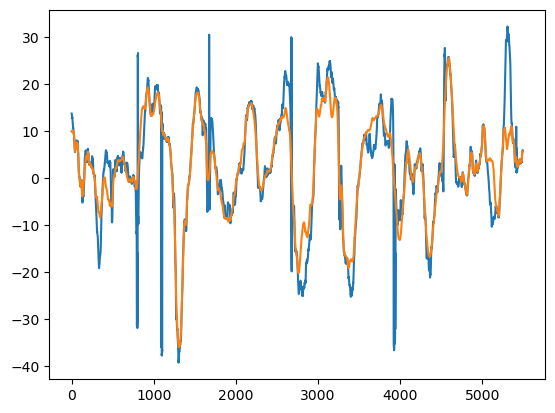

In [10]:
wheel_angle_pred_sanity = []

for i in range(HIST_COEF, len(road_angle_clean)):
    past_hist_samples = road_angle_clean[i - HIST_COEF:i]

    pred = model.predict(past_hist_samples.reshape(1, -1))

    wheel_angle_pred_sanity.append(pred)

plt.plot(wheel_angle_ts_arr)
plt.plot(wheel_angle_pred_sanity)

In [11]:
# Open the video file
input_video_path = 'data/audi_gravel_road_footage.mp4'
output_video_path = 'result_audi_v1.mp4'
video_capture = cv2.VideoCapture(input_video_path)

fcount = 0
x_data = []

# Get the frame rate and frame size
frame_rate = int(video_capture.get(cv2.CAP_PROP_FPS))
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

start_frame = int(0 * frame_rate)
end_frame = int(60 * frame_rate)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (frame_width, frame_height))

# Loop through frames
while True:
    # Read a frame from the video
    ret, frame = video_capture.read()

    # Check if the frame is successfully read
    if not ret:
        break

    try:
        road_frame = crop_road_snippet(frame)
        road_frame, road_angle = segment_gravel_road(road_frame)
        
        wheel_frame = crop_steering_wheel(frame)
        c1, c2 = segment_hands(wheel_frame)

        x_data.append(road_angle)

        fcount += 1
    except:
        continue

    if fcount < HIST_COEF:
        continue
    
    cv2.line(frame, c1 + WHEEL_OFFSET, c2 + WHEEL_OFFSET, (0, 255, 0), 2)
    cv2.circle(frame, c1 + WHEEL_OFFSET, 15, (255, 0, 0), -1)
    cv2.circle(frame, c2 + WHEEL_OFFSET, 15, (255, 0, 0), -1)

    angle = angle_of_wheel_line(c1, c2)

    pred_angle = model.predict(np.array(x_data[-500:]).reshape(1, -1))

    whl_ctr = np.mean([c1, c2], axis=0)
    line_m = np.tan(np.deg2rad(pred_angle[0]))

    d1 = np.array([
        c1[0], int(whl_ctr[1] - abs(whl_ctr[0] - c1[0])*line_m)
    ])
    d2 = np.array([
        c2[0], int(whl_ctr[1] + abs(whl_ctr[0] - c2[0])*line_m)
    ])

    cv2.line(frame, d1 + WHEEL_OFFSET, d2 + WHEEL_OFFSET, (0, 0, 255), 2)

    cv2.putText(frame, f"Prediction: {pred_angle[0]:.4f}", (10, 20), 1, 2, (0, 255, 0))
    cv2.putText(frame, f"Truth: {angle:.4f}", (10, 60), 1, 2, (0, 255, 0))

    # Display the frame
    #cv2.imshow('Frame', frame)

    # # Wait for key press
    # key = cv2.waitKey(0) & 0xFF

    # # Quit if 'q' is pressed
    # if key == ord('q'):
    #     break

    # Write frame to the output video if it falls within the specified time range
    if start_frame <= video_capture.get(cv2.CAP_PROP_POS_FRAMES) <= end_frame:
        output_video.write(frame)
    
    if video_capture.get(cv2.CAP_PROP_POS_FRAMES) >= end_frame:
        break

# Release video capture
video_capture.release()
cv2.destroyAllWindows()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
